In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


In [2]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
df.shape

(17414, 10)

In [4]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:17414, 1:2]

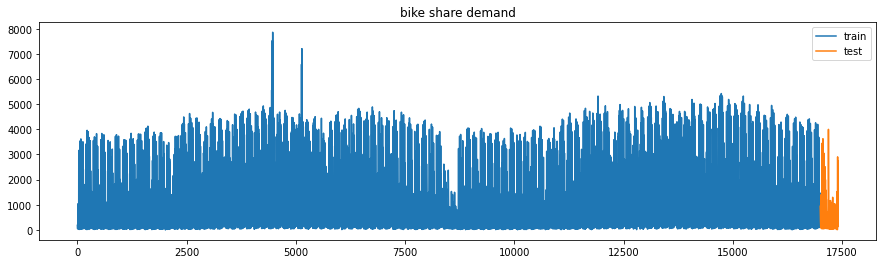

In [5]:
df['cnt'][:17000].plot(figsize=(15, 4), legend=True)
df['cnt'][17000:].plot(figsize=(15, 4), legend=True)

import matplotlib.pyplot as plt

plt.legend(['train', 'test'])
plt.title('bike share demand')
plt.show()

## 시계열 차수 추정
: 몇시간 뒤를 추정할건지~?

In [6]:
from statsmodels.tsa.stattools import pacf  #차수 추정 방법 중 하
pacf = pacf(df['cnt'], nlags=21, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713  0.13216383]


<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

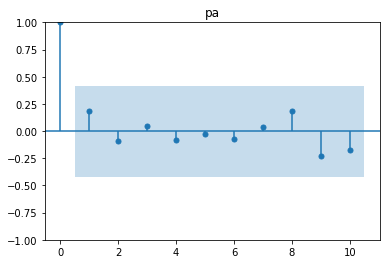

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=10, method='ols', title='pa').show
#nlags의 50%보다 작아야한다던데??

결과적으로, 한 시간 전 데이터를 이용해서 추정하겠다

## 데이터 전처리

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

train_scaled = sc.fit_transform(train)
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [9]:
X_train = []
y_train = []

#데이터 한시간 전으로 shift 시키기
for i in range(1, 17000):
    X_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
#3차원 배열로 만들어주
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(16999, 1, 1)

## RNN
: 과거의 입력값을 활용해서 결과값을 구함, sequence나 시계열 데이터에 많이 활용

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN

In [12]:
rnn = Sequential()
rnn. add(SimpleRNN(activation='relu', units=6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1))

2022-07-18 07:17:02.726206: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
print(rnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 6)                 48        
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])
#최적화는 통상적으로 아담 많이 사용

rnn.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2


2022-07-18 07:17:03.050900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


16999/16999 [==============================] - 26s 1ms/step - loss: 0.0082 - mse: 0.0082
Epoch 2/2
16999/16999 [==============================] - 25s 1ms/step - loss: 0.0068 - mse: 0.0068


In [15]:
inputs = sc.transform(test)
inputs.shape

(414, 1)

In [16]:
X_test = []

for i in range(1, 415) :
    X_test.append(inputs[i-1:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(414, 1, 1)

In [17]:
rnn = rnn.predict(X_test)
rnn = sc.inverse_transform(rnn)

In [18]:
test1 = pd.DataFrame(test)
rnn1 = pd.DataFrame(rnn)

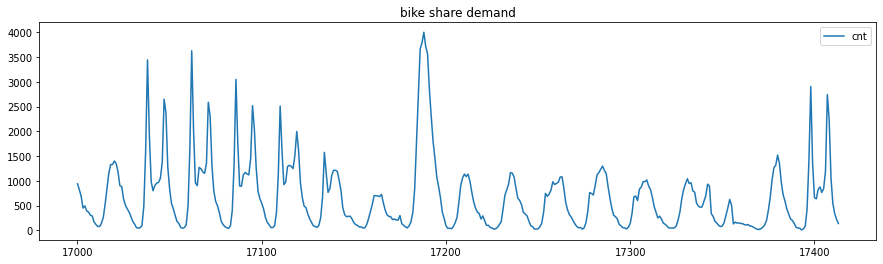

In [19]:
test1.plot(figsize=(15, 4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

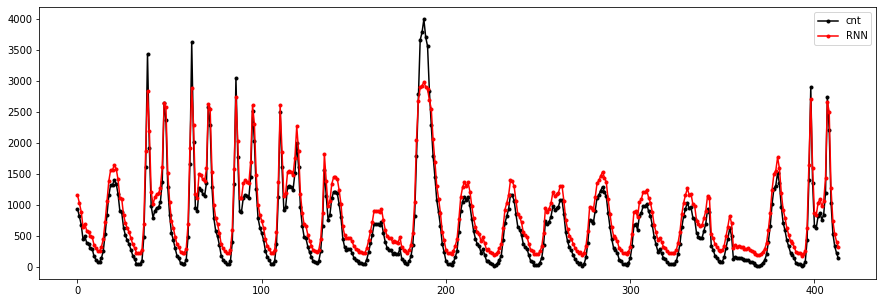

In [20]:
test = np.array(test)

plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')
plt.legend()

## LSTM

In [21]:
from keras.layers.recurrent import LSTM

lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1,1)))
lstm.add(Dense(units=1, activation='linear'))

In [22]:
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
None


parameter가 많으면 성능이 좋아질 수도 있지만 과적합의 위험도 있음

In [23]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 36s 2ms/step - loss: 0.0080 - mse: 0.0080
Epoch 2/2
16999/16999 [==============================] - 34s 2ms/step - loss: 0.0068 - mse: 0.0068


In [24]:
lstm = lstm.predict(X_test)
lstm = sc.inverse_transform(lstm)

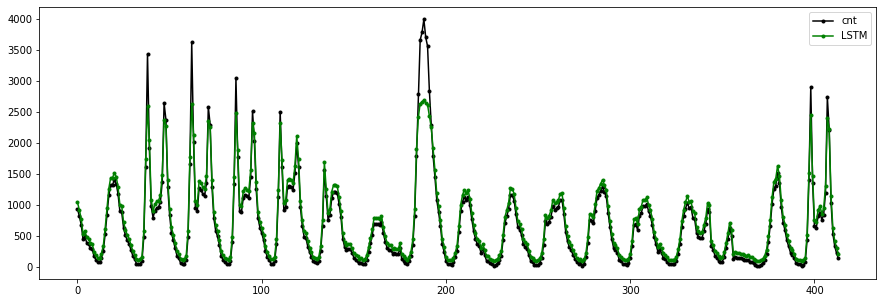

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(lstm, marker='.', label='LSTM', color='green')
plt.legend()

## GRU
: lstm의 오버피팅 문제를 해결

In [26]:
from keras.layers.recurrent import GRU

gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation='linear'))

In [27]:
print(gru.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
None


lstm에 비해 parameter 수가 적음, lstm보다는 많음, 성능을 유지하면서 과적합 방지

In [28]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 34s 2ms/step - loss: 0.0197 - mse: 0.0197
Epoch 2/2
16999/16999 [==============================] - 34s 2ms/step - loss: 0.0193 - mse: 0.0193


In [29]:
gru = gru.predict(X_test)
gru = sc.inverse_transform(gru)

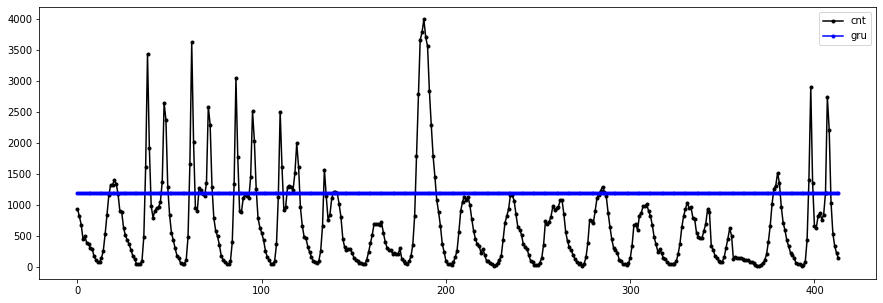

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(gru, marker='.', label='gru', color='blue')
plt.legend()

## 모형별 비교

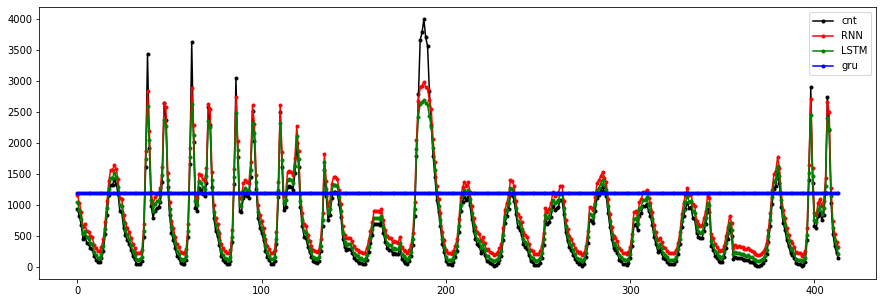

In [31]:
plt.figure(figsize=(15, 5))

plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')
plt.plot(lstm, marker='.', label='LSTM', color='green')
plt.plot(gru, marker='.', label='gru', color='blue')

plt.legend()

In [32]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict) :
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [33]:
print("RNN RMSE: ", RMSE(test, rnn))
print("LSTM RMSE: ", RMSE(test, lstm))
print("GRU RMSE: ", RMSE(test, gru))

RNN RMSE:  226.29229915966266
LSTM RMSE:  170.94324760538674
GRU RMSE:  875.0134283933152
